In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi as π
import firedrake
from firedrake import as_vector, inner, ds
import icepack, icepack.plot, icepack.models, icepack.solvers

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance
firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


### Making the geometry

In [2]:
import pygmsh

R = 200e3
δx = 5e3

In [3]:
geometry = pygmsh.built_in.Geometry()

x1 = geometry.add_point([-R, 0, 0], lcar=δx)
x2 = geometry.add_point([+R, 0, 0], lcar=δx)

center1 = geometry.add_point([0, 0, 0,], lcar=δx)
center2 = geometry.add_point([0, -4 * R, 0], lcar=δx)

arcs = [geometry.add_circle_arc(x1, center1, x2),
        geometry.add_circle_arc(x2, center2, x1)]

In [4]:
line_loop = geometry.add_line_loop(arcs)
plane_surface = geometry.add_plane_surface(line_loop)

physical_lines = [geometry.add_physical(arc) for arc in arcs]
physical_surface = geometry.add_physical(plane_surface)

In [5]:
with open('ice-shelf.geo', 'w') as geo_file:
    geo_file.write(geometry.get_code())

In [6]:
!gmsh -2 -format msh2 -o ice-shelf.msh ice-shelf.geo

Info    : Running 'gmsh -2 -format msh2 -o ice-shelf.msh ice-shelf.geo' [Gmsh 4.11.1, 1 node, max. 1 thread]
Info    : Started on Tue Sep 12 13:43:11 2023
Info    : Reading 'ice-shelf.geo'...
Info    : Done reading 'ice-shelf.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 50%] Meshing curve 2 (Circle)
Info    : Done meshing 1D (Wall 0.000448714s, CPU 0.000374s)
Info    : Meshing 2D...
Info    : Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : Running 'gmsh -2 -format msh2 -o ice-shelf.msh ice-shelf.geo' [Gmsh 4.11.1, 1 node, max. 1 thread]
Info    : Started on Tue Sep 12 13:43:11 2023
Info    : Reading 'ice-shelf.geo'...
Info    : Done reading 'ice-shelf.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 50%] Meshing curve 2 (Circle)
Info    : Done meshing 1D (Wall 0.000448714s, CPU 0.000374s)
Info    : Meshing 2D...
Info    : Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.110082s, C

In [7]:
mesh = firedrake.Mesh('ice-shelf.msh')

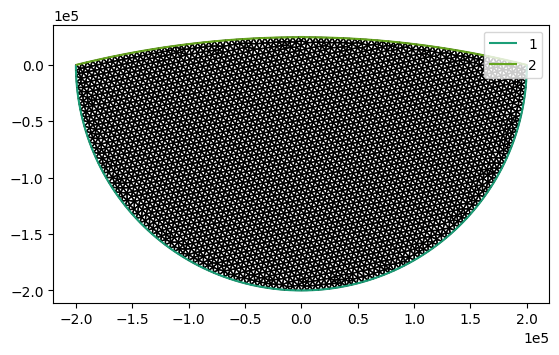

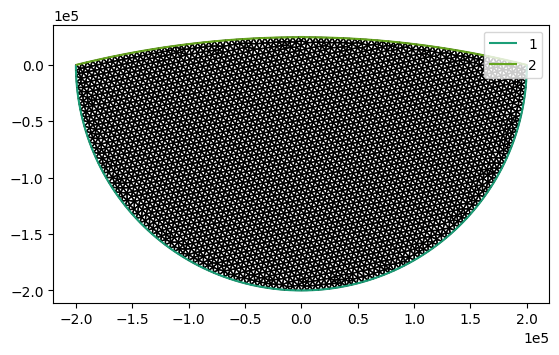

In [8]:
fig, axes = icepack.plot.subplots()
icepack.plot.triplot(mesh, axes=axes)
axes.legend()
plt.show(fig)

### Input data

In [9]:
inlet_angles = π * np.array([-3/4, -1/2, -1/3, -1/6])
inlet_widths = π * np.array([1/8, 1/12, 1/24, 1/12])

In [10]:
x = firedrake.SpatialCoordinate(mesh)

u_in = 300
h_in = 350
hb = 100
dh, du = 400, 250

hs, us = [], []
for θ, ϕ in zip(inlet_angles, inlet_widths):
    x0 = R * as_vector((np.cos(θ), np.sin(θ)))
    v = -as_vector((np.cos(θ), np.sin(θ)))
    L = inner(x - x0, v)
    W = x - x0 - L * v
    Rn = 2 * ϕ / π * R
    q = firedrake.max_value(1 - (W / Rn)**2, 0)
    hs.append(hb + q * ((h_in - hb) - dh * L /R))
    us.append(firedrake.exp(-4 * (W/R)**2) * (u_in + du * L / R) * v)

In [11]:
from icepack.constants import ice_density as ρ_I, water_density as ρ_W
b0 = -ρ_I / ρ_W * h_in - 100.

In [12]:
h_expr = firedrake.Constant(hb)
for h in hs:
    h_expr = firedrake.max_value(h, h_expr)
    
u_expr = sum(us)
b_expr = firedrake.Constant(b0)

In [13]:
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2)
V = firedrake.VectorFunctionSpace(mesh, family='CG', degree=2)

h0 = firedrake.interpolate(h_expr, Q)
b = firedrake.interpolate(b_expr, Q)
u0 = firedrake.interpolate(u_expr, V)

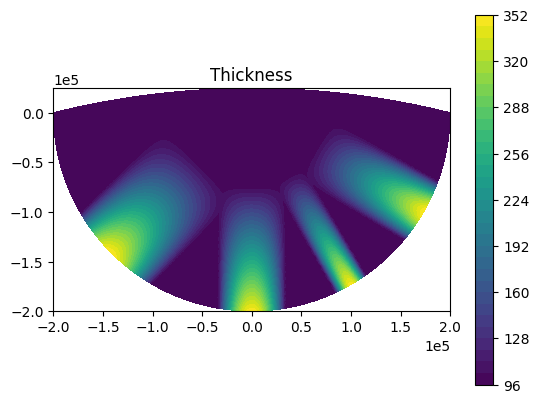

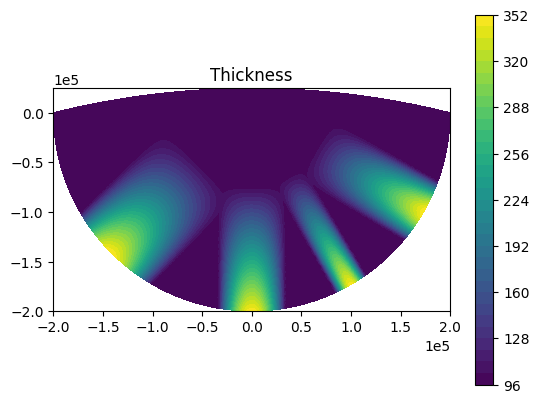

In [14]:
fig, axes = icepack.plot.subplots()
axes.set_title('Thickness')
contours = icepack.plot.tricontourf(h0, 40, axes=axes)
fig.colorbar(contours)

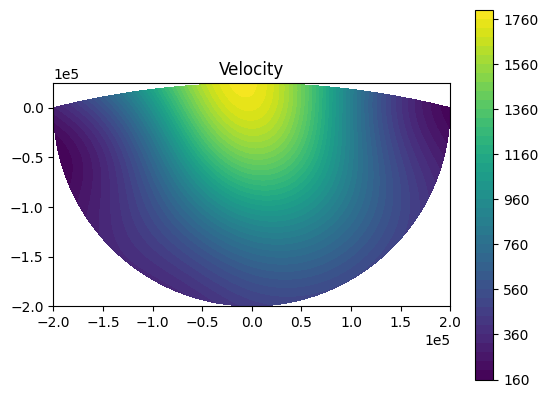

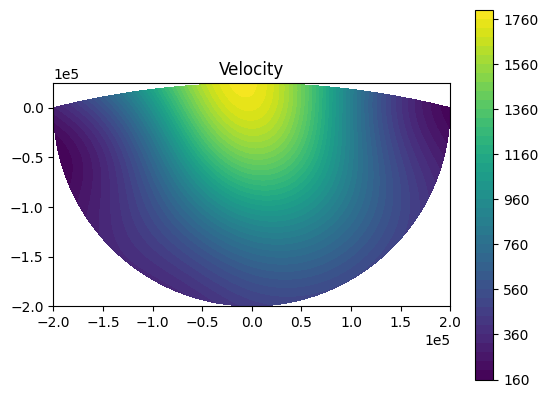

In [15]:
fig, axes = icepack.plot.subplots()
axes.set_title('Velocity')
contours = icepack.plot.tricontourf(u0, 40, axes=axes)
fig.colorbar(contours)

### Modeling

In [16]:
from icepack.constants import gravity as g
def friction(u, h, s, C):
    p_W = ρ_W * g * firedrake.max_value(0, h - s)
    p_I = ρ_I * g * h
    ϕ = 1 - p_W / p_I
    return icepack.models.friction.bed_friction(u, C * ϕ)

model = icepack.models.IceStream(friction=friction)
opts = {'dirichlet_ids': [1], 'tolerance': 1e-12}
solver = icepack.solvers.FlowSolver(model, **opts)

We'll tune the friction coefficient so that ice grounded above sea level flowing at 512 m/year (shut up, it's a cube...) will experience a basal shear stress of 100 kPa.

In [17]:
T = firedrake.Constant(255.15)
A = firedrake.interpolate(icepack.rate_factor(T), Q)

from icepack.constants import weertman_sliding_law as m
C = firedrake.Constant(.1 / 512**(1/m))

In [20]:
h = h0.copy(deepcopy=True)
s = icepack.compute_surface(h=h, b=b)
u = solver.diagnostic_solve(u=u0, h=h, s=s, A=A, C=C)


TypeError: bed_friction() takes 0 positional arguments but 2 were given

TypeError: bed_friction() takes 0 positional arguments but 2 were given

In [ ]:
help(solver.diagnostic_solve)

In [ ]:
fig, axes = icepack.plot.subplots()
streamlines = icepack.plot.streamplot(u, precision=1e3, density=2e3, axes=axes)
fig.colorbar(streamlines, label='meters/year')
plt.show(fig)

In [ ]:
import tqdm

final_time = 400.
num_timesteps = 200
dt = final_time / num_timesteps
a = firedrake.Constant(0.0)

for step in tqdm.trange(num_timesteps):
    h = solver.prognostic_solve(dt, h=h, a=a, u=u, h_inflow=h0)
    s = icepack.compute_surface(h=h, b=b)
    u = solver.diagnostic_solve(u=u, h=h, s=s, A=A, C=C, **opts)

In [ ]:
fig, axes = icepack.plot.subplots()
contours = icepack.plot.tricontourf(h, 40, axes=axes)
fig.colorbar(contours, label='meters')
plt.show(fig)

In [ ]:
fig, axes = icepack.plot.subplots()
streamlines = icepack.plot.streamplot(u, precision=1e3, density=2e3, axes=axes)
fig.colorbar(streamlines, label='meters/year')
plt.show(fig)

### Adding an ice rise

Now let's add something like a seamount!
We'll make it come to within 90m of sea level, it'll be located at coordinates $(30.0, -75)$ km, and it'll have a radius of 50 km.

In [ ]:
db = -90 - b0
x = firedrake.SpatialCoordinate(mesh)
x0 = firedrake.Constant((30e3, -75e3))
r = firedrake.Constant(50e3)
b_expr = b0 + db * firedrake.exp(-inner(x - x0, x - x0) / r**2)
b = firedrake.interpolate(b_expr, Q)

In [ ]:
fig, axes = icepack.plot.subplots()
contours = icepack.plot.tricontourf(b, axes=axes)
fig.colorbar(contours)

In [ ]:
s = icepack.compute_surface(h=h, b=b)
u = solver.diagnostic_solve(u=u, h=h, s=s, A=A, C=C)

In [ ]:
fig, axes = icepack.plot.subplots()
streamlines = icepack.plot.streamplot(u, precision=1e3, density=2e3, axes=axes)
fig.colorbar(streamlines, label='meters/year')
plt.show(fig)

In [ ]:
for step in tqdm.trange(num_timesteps):
    h = solver.prognostic_solve(dt, h=h, a=a, u=u, h_inflow=h0)
    s = icepack.compute_surface(h=h, b=b)
    u = solver.diagnostic_solve(u=u, h=h, s=s, A=A, C=C)

In [ ]:
fig, axes = icepack.plot.subplots()
axes.set_xlabel('x (km)')
axes.set_ylabel('y (km)')
axes.set_title('Ice velocity')
streamlines = icepack.plot.streamplot(u, precision=1e3, density=2e3, axes=axes)
fig.colorbar(streamlines, label='meters/year', fraction=0.0265, pad=0.04)

In [ ]:
fig, axes = icepack.plot.subplots()
axes.set_xlabel('x (km)')
axes.set_ylabel('y (km)')
axes.set_title('Ice thickness')
contours = icepack.plot.tricontourf(h, 40, axes=axes)
fig.colorbar(contours, label='meters', fraction=0.0265, pad=0.04)